# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [55]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [56]:
# Add any additional import statements you need here
import json
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict


In [57]:
# NOTE from KB: I decided to move the twitter and lyrics files manually
# change `data_location` to the location of the folder on your machine.
# data_location = "/users/rsadeghian/textmining/ads-tm-api-scrape/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [58]:
# Read in the lyrics data

lyrics_data = defaultdict(lambda: defaultdict(str))

# Loop through each artist folder within the lyrics folder
for artist_folder in os.listdir(lyrics_folder):
    artist_path = os.path.join(lyrics_folder, artist_folder)
    if os.path.isdir(artist_path):  
        for song_file in os.listdir(artist_path):
            if song_file.endswith(".txt"): 
                song_title = song_file.replace('.txt', '')
                with open(os.path.join(artist_path, song_file), 'r', encoding='utf-8') as f:
                    lyrics_data[artist_folder][song_title] = f.read()

In [59]:
# Inspecting that the lyrics data was pulled correctly
for artist, songs in list(lyrics_data.items())[:2]:  
    print(f"Artist: {artist}")
    for song, lyrics in list(songs.items())[:2]:  
        print(f"  Song: {song}")
        print(f"  Lyrics (first 100 characters): {lyrics[:100]}")  
        print("\n")  

Artist: joni
  Song: jonimitchell_ladiesofthecanyon
  Lyrics (first 100 characters): "Ladies Of The Canyon"

Trina wears her wampum beadsShe fills her drawing book with linesSewing lace


  Song: jonimitchell_bothsidesnow
  Lyrics (first 100 characters): "Both Sides Now"

Rows and floes of angel hairAnd ice cream castles in the airAnd feather canyons ev


Artist: kanye
  Song: kanyewest_golddigger
  Lyrics (first 100 characters): "Gold Digger"

[Jamie Foxx:]She take my money when I'm in needYeah, she's a triflin' friend indeedOh


  Song: kanyewest_intro
  Lyrics (first 100 characters): "Intro"

[DeRay Davis:]Kanye, can I talk to you for a minute?Me and the other faculty members was wo




In [60]:
# Read in the twitter data

twitter_folder = "twitter/"

# Initialize a dictionary to store the descriptions
twitter_data = defaultdict(list)

# List all files in the twitter folder that end with '_followers_data.txt'
twitter_files = [f for f in os.listdir(twitter_folder) if f.endswith('_followers_data.txt')]

# Loop through each file in the list
for twitter_file in twitter_files:
    artist_name = twitter_file.replace('_followers_data.txt', '')  # Extract the artist name from the file name
    with open(os.path.join(twitter_folder, twitter_file), 'r', encoding='utf-8') as f:
        for line in f:
            twitter_data[artist_name].append(line.strip())  # Read each line as a description and add it to the list

In [61]:
# To check if the twitter data was loaded correctly
for artist, descriptions in list(twitter_data.items())[:2]:  
    print(f"Artist: {artist}")
    for description in descriptions[:5]:  
        print(f"  Description: {description[:100]}")  
        print("\n")  

Artist: cher
  Description: screen_name	name	id	location	followers_count	friends_count	description


  Description: hsmcnp	Country Girl	35152213		1302	1014


  Description: horrormomy	Jeny	742153090850164742	Earth	81	514	𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜


  Description: anju79990584	anju	1496463006451974150		13	140	163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡


  Description: gallionjenna	J	3366479914		752	556	csu


Artist: robynkonichiwa
  Description: screen_name	name	id	location	followers_count	friends_count	description


  Description: AngelxoArts	Angelxo	1424055675030806529	Zacatlan, Puebla, Mexico	29	535	"I love chill" •Facebook / I


  Description: songsfornikola	johnny	1502717352575651840		6	318	books, movies, music, nature & TV shows. OG Sweetee


  Description: thibaud_lola	Thibaud Lola	1502407708246478852		3	69	(Am)auteur en herbe 🌱 - juriste en paille 🤡 - Am


  Description: KyleSew2112	Kyle S 🌹🇬🇧🇺🇦	3423966821	South East London	1258	3444	This Twitter profile is full of

In [62]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Read in positive and negative words and assign scores
positive_words = pd.read_csv('positive-words.txt', comment=';', header=None, names=['word'])
positive_words['score'] = 1

negative_words = pd.read_csv('negative-words.txt', comment=';', header=None, names=['word'])
negative_words['score'] = -1

# Combine both into a single DataFrame
sentiment_words_df = pd.concat([positive_words, negative_words])

# Read in the tidytext sentiments
tidytext_sentiments = pd.read_csv('tidytext_sentiments.txt', delimiter='\t')

# Now you can map the sentiment to scores, assuming 'positive' is +1 and 'negative' is -1
tidytext_sentiments['score'] = tidytext_sentiments['sentiment'].map({'positive': 1, 'negative': -1})


In [63]:
# Checking that the pandas Dataframe is set up how we want for sentiment_words_df
sentiment_words_df.head()

,word,score
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


In [64]:
# Checking that the pandas Dataframe is set up how we want for tidytext_sentiments
tidytext_sentiments.head()

,word,sentiment,lexicon,score
0,abandon,negative,nrc,-1
1,abandoned,negative,nrc,-1
2,abandonment,negative,nrc,-1
3,abba,positive,nrc,1
4,abduction,negative,nrc,-1


In [65]:
# Combining the two dataframes
combined_sentiments_df = pd.concat([sentiment_words_df, tidytext_sentiments[['word', 'score']]])
combined_sentiments_df.head()

,word,score
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [66]:
# Defining the function to calculate sentiment
def calculate_sentiment_df(lyrics, sentiment_df):
    # Tokenize the lyrics into words
    words = lyrics.split()
    # Initialize sentiment score
    sentiment_score = 0
    # Look up each word in the sentiment DataFrame and sum their scores
    for word in words:
        if word in sentiment_df['word'].values:
            sentiment_score += sentiment_df.loc[sentiment_df['word'] == word, 'score'].sum()
    return sentiment_score


In [67]:
# Applying the sentiment calculation to each song
sentiment_results = defaultdict(dict)

for artist in lyrics_data:
    for song, lyrics in lyrics_data[artist].items():
        sentiment_score = calculate_sentiment_df(lyrics, combined_sentiments_df)
        sentiment_results[artist][song] = sentiment_score


In [68]:
# Calculating sentiment score per artist

average_sentiment_per_artist = {}

for artist, songs in sentiment_results.items():
    average_score = sum(songs.values()) / len(songs) if songs else 0
    average_sentiment_per_artist[artist] = average_score

# Display the average sentiment score per artist
for artist, avg_score in average_sentiment_per_artist.items():
    print(f"Artist: {artist}, Average Sentiment Score: {avg_score}")


Artist: joni, Average Sentiment Score: 1.84
Artist: kanye, Average Sentiment Score: 13.4


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: The artist with the higher sentiment per song is Kanye West, by a mile. This means Kanye's songs, on average, have a higher positive sentiment. Nonetheless, Joni still has a slightly positive sentiment in her songs. The score can be less than zero, and I would imagine artists such as Korn or Slipknot would be in the negative, given that their songs are generally very negative in their lyrical content. It does crack me up that Kanye's is so high, at least compared to Joni. It is also a little surprising, as I can think of many Kanye songs that are negative in their lyrical content. 

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Results below, starting with Kanye West. The results are close to what I was thinking, actually. The song selection is from the first 25 songs of Kanye West's catalogue, which is primarily the album "College Dropout." This is a socially conscious album, before Kanye was as experimental in his music as he became in the 2010s. The driver of the negative sentiment are "All Falls Down" and "Jesus Walks." I specifically had "Jesus Walks" and also "We Don't Care" as songs that would likely show up in the negative sentiment, though "We Don't Care" did not crack the top 3. "Jesus Walks" is a song critical of modern society and uses dramatic language from the bible to talk about the world as it was in 2004 (the fear of Terrorism being predominant). "All Falls Down" is also one of my favorites, and talks about the problems with consumer culture in America. "Slow Jamz" is the top highest sentiment song, and is very much an R&B song featuring none other than Jamie Foxx. It is a song featuring romance and is a "feel good" pleasant song to listen to. 

In [69]:
# First, need to sort the songs by sentiment score for Kanye
artist_songs = sentiment_results['kanye']

# Sort the songs by sentiment score in descending order and then in ascending order 
highest_songs = sorted(artist_songs.items(), key=lambda x: x[1], reverse=True)[:3]
lowest_songs = sorted(artist_songs.items(), key=lambda x: x[1])[:3]

In [70]:
# Print the lyrics of the songs
print("Songs with Highest Sentiments:")
for song, _ in highest_songs:
    print(f"\nSong: {song}\nLyrics:\n{lyrics_data['kanye'][song]}")

print("\nSongs with Lowest Sentiments:")
for song, _ in lowest_songs:
    print(f"\nSong: {song}\nLyrics:\n{lyrics_data['kanye'][song]}")


Songs with Highest Sentiments:

Song: kanyewest_slowjamz
Lyrics:
"Slow Jamz"

[Jamie Foxx:]Kanye, it's Foxx, manI'm just sayin' I was talkin' to the girls you knowAnd we don't put enough emphasis on the ladies sometimeYou know, I was talkin' to this girlShe was talkin' about the music all fast in the club you knowShe gotta drink water 'cause she thirstyShe danced like 92 hundred songs back to backWith ain't nobody really try to find out what she feelin'Like how she feel... you know what she told me?(Are you gonna be?) Check it out, this is what she said(Say that you're gonna be) Ooh, ooh, ooh, ooh, oooh[Luther Vandross:]Are you gonna be?Say that you're gonna be[Jamie Foxx:]Oh oh oh oh oh[Jamie Foxx:]She said she want some Marvin Gaye, some Luther Vandross, a little Anita, will definitely set this party off right(Are you gonna be, are you gonna be, are you gonna be, are you gonna be, are you gonna be? Well well well well well)She said she want some Ready for the World, some New Edition,

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Joni Mitchell writes in her best albums about melancholy things. She is sort of a melancholy person who, despite her great artistry, is known to be difficult to be around. She does occasionally write about positive things. The song "Dawntreader", as well as many of her early songs before she started to find her voice on the album "Clouds", were very much inspired by the peace-loving hippies of the 1960s. Her first album "Song to a Seagull" is basically a snoozer copy of 1960s soft rock inspired by LSD. There are words about "love", "treasure", and "smiling." I am not as intimately familiar with the songs in the negative sentiment list, but I see that the top song is "Nathan La Franeer." Words like "never", "furrowed", and "burglar" seem to drive the negative sentiment of this song. 


In [71]:
# First, need to sort the songs by sentiment score for Joni
artist_songs = sentiment_results['joni']

# Sort the songs by sentiment score in descending order and then in ascending order 
highest_songs = sorted(artist_songs.items(), key=lambda x: x[1], reverse=True)[:3]
lowest_songs = sorted(artist_songs.items(), key=lambda x: x[1])[:3]

In [72]:
# Print the lyrics of the songs
print("Songs with Highest Sentiments:")
for song, _ in highest_songs:
    print(f"\nSong: {song}\nLyrics:\n{lyrics_data['joni'][song]}")

print("\nSongs with Lowest Sentiments:")
for song, _ in lowest_songs:
    print(f"\nSong: {song}\nLyrics:\n{lyrics_data['joni'][song]}")

Songs with Highest Sentiments:

Song: jonimitchell_thedawntreader
Lyrics:
"The Dawntreader"

Peridots and periwinkle blue medallionsGilded galleons spilled across the ocean floorTreasure somewhere in the sea and he will find whereNever mind their questions there's no answer forThe roll of the harbor wakeThe songs that the rigging makesThe taste of the spray he takesAnd he learns to giveHe aches and he learns to liveHe stakes all his silverOn a promise to be freeMermaids live in coloniesAll his seadreams come to meCity satins left at home I will not need themI believe him when he tells of loving meSomething truthful in the sea your lies will find youLeave behind your streets he said and come to meCome down from the neon nightsCome down from the tourist sightsRun down till the rain delights youYou do not hideSunlight will renew your prideSkin white by skin goldenLike a promise to be freeDolphins playing in the seaAll his seadreams come to meSeabird I have seen you fly above the pilingsI 

Q: Plot the distributions of the sentiment scores for both artists. 
You can use `seaborn` to plot densities or plot histograms in matplotlib.

In [73]:
# First we need to create a DataFrame from the dictionary of sentiment_results

# Flatten the sentiment_results dictionary into a list of tuples
data = []
for artist, songs in sentiment_results.items():
    for song, score in songs.items():
        data.append((artist, song, score))

# Create a DataFrame from the list
sentiment_results_df = pd.DataFrame(data, columns=['Artist', 'Song', 'SentimentScore'])

# Show the first few rows to verify
print(sentiment_results_df.head())

  Artist                               Song  SentimentScore
0   joni     jonimitchell_ladiesofthecanyon               8
1   joni          jonimitchell_bothsidesnow               0
2   joni  jonimitchell_idontknowwhereistand              -7
3   joni                jonimitchell_marcie               3
4   joni             jonimitchell_ihadaking              -6


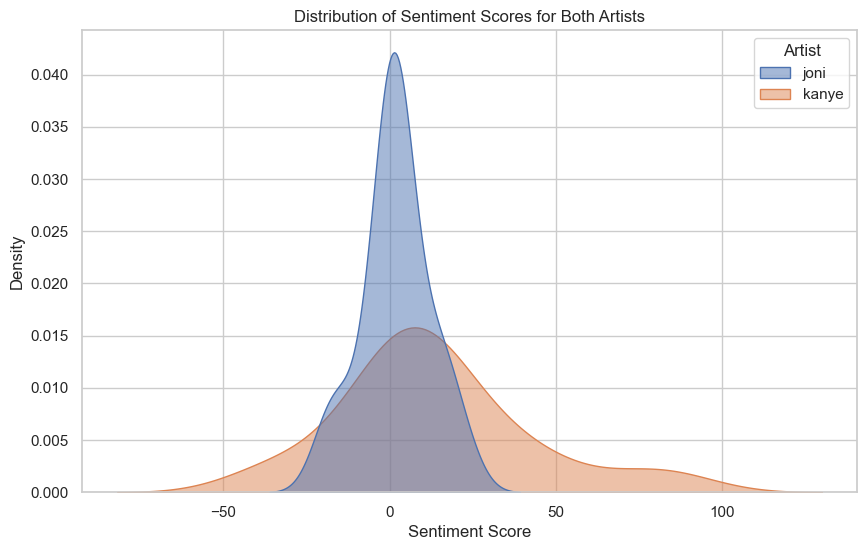

In [74]:
# Plotting the results
plt.figure(figsize=(10, 6))
sns.kdeplot(data=sentiment_results_df, x="SentimentScore", hue="Artist", fill=True, common_norm=False, alpha=0.5)
plt.title('Distribution of Sentiment Scores for Both Artists')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()


## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [75]:
# your code here

# We start by setting the emoji sets
positive_emojis = set(["😊", "😍", "❤️", "👍", "😁", "💕", "🎉", "✨", "🤣", "😇"])
negative_emojis = set(["😠", "😢", "💔", "👎", "😡", "😞", "😥", "🤬", "😓", "😩"])

# Define a function to calculate sentiment scores
def calculate_emoji_sentiment(descriptions, positive_emojis, negative_emojis):
    score = 0
    for description in descriptions:
        for emoji in positive_emojis:
            score += description.count(emoji)
        for emoji in negative_emojis:
            score -= description.count(emoji)
    return score

# Set up a dictionary to contain the average sentiment per artist
average_sentiment_per_artist = {}

for artist, descriptions in twitter_data.items():
    total_score = calculate_emoji_sentiment(descriptions, positive_emojis, negative_emojis)
    average_sentiment = total_score / len(descriptions) if descriptions else 0
    average_sentiment_per_artist[artist] = average_sentiment

# Display the average emoji sentiment score per artist
for artist, avg_score in average_sentiment_per_artist.items():
    print(f"Artist: {artist}, Average Emoji Sentiment Score: {avg_score}")


Artist: cher, Average Emoji Sentiment Score: 0.03401293279970682
Artist: robynkonichiwa, Average Emoji Sentiment Score: 0.02235101416680386


Q: What is the average sentiment of your two artists? 

A: The average sentiment sentiment score in the twitter data is higher for Cher than it is for Robyn, based on the emojis we defined. It is about 50% higher, indicating Cher has an overall much higher positive sentiment than Robyn.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: For both artists, the most popular positive emoji is the small black heart while the most popular negative emoji is the broken red heart. 



In [77]:
# First we set up a function to count the emojis
def count_emojis(descriptions, emoji_set):
    emoji_counts = defaultdict(int)
    for description in descriptions:
        for emoji in emoji_set:
            emoji_counts[emoji] += description.count(emoji)
    return emoji_counts

# Setting up a dictionary to contain the most popular emojis per artist
most_popular_emojis_per_artist = {}

for artist, descriptions in twitter_data.items():
    # Count the frequency of positive and negative emojis
    positive_emoji_counts = count_emojis(descriptions, positive_emojis)
    negative_emoji_counts = count_emojis(descriptions, negative_emojis)
    
    # Find the most popular positive and negative emoji
    most_popular_positive = max(positive_emoji_counts, key=positive_emoji_counts.get, default="N/A")
    most_popular_negative = max(negative_emoji_counts, key=negative_emoji_counts.get, default="N/A")
    
    most_popular_emojis_per_artist[artist] = {
        "Most Popular Positive Emoji": most_popular_positive,
        "Most Popular Negative Emoji": most_popular_negative,
        "Positive Emoji Count": positive_emoji_counts[most_popular_positive] if most_popular_positive != "N/A" else 0,
        "Negative Emoji Count": negative_emoji_counts[most_popular_negative] if most_popular_negative != "N/A" else 0,
    }

# Display the most popular emojis for each artist
for artist, info in most_popular_emojis_per_artist.items():
    print(f"Artist: {artist}")
    print(f"  Most Popular Positive Emoji: {info['Most Popular Positive Emoji']} (Count: {info['Positive Emoji Count']})")
    print(f"  Most Popular Negative Emoji: {info['Most Popular Negative Emoji']} (Count: {info['Negative Emoji Count']})\n")


Artist: cher
  Most Popular Positive Emoji: ❤️ (Count: 55206)
  Most Popular Negative Emoji: 💔 (Count: 2001)

Artist: robynkonichiwa
  Most Popular Positive Emoji: ❤️ (Count: 3461)
  Most Popular Negative Emoji: 💔 (Count: 72)

